# Model Inputs

### Packages

In [1]:
# General
import pandas as pd
import numpy as np
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
import umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Classfication
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Visualization
import plotly.express as px
import plotly.graph_objects as go

### Dataset

In [2]:
# Loading output dataframe from data.ipynb
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

# Filter non-specific ec numbers (e.g., 1.1.1,-)
filter = df["ec"].str.contains("-")
df = df[~filter]

# Format for machine learning
df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering into training and test sets (database set vs. MAGs)
bins = df["media_id"].str.contains("unknown")
df_train = df[~bins]
df_test = df[bins]

### Split dataset

In [3]:
# Split the datasets into training and test sets
TARGET = "media_id" # target label
RANDOM_SEED = 47 #47 = seed for random_state reported in thesis

# Test case with MAGs
X_train = df_train.drop(["taxon_id", "media_id"], axis=1)
y_train = df_train[TARGET] 
X_test = df_test.drop(["taxon_id", "media_id"], axis=1)
y_test = df_test[TARGET]

# Model

### Pipeline

In [4]:
# sklearn pipeline helps prevent data leakage; incorporate individual steps here
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(
        n_components=150,      
        random_state= RANDOM_SEED
        )),    
    ('umap', umap.UMAP(      
        metric="euclidean",
        n_epochs=500,
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=40, 
        n_neighbors=62, 
        min_dist=0 
        )) 
])

### Fit and transform

In [5]:
# Fit and transform the pipeline on the training and test data
X_train_transformed = pipeline.fit_transform(X_train) # fit pipeline and transform training data
X_test_transformed = pipeline.transform(X_test) # transform test data

### Cluster

In [6]:
# Cluster
clusterer = KMeans(n_clusters=182, random_state=RANDOM_SEED)
cluster_labels = clusterer.fit_predict(X_train_transformed)
test_clusters = clusterer.predict(X_test_transformed)

### Metrics

In [7]:
# Initial dimensionality reduction performance (PCA)
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

# UMAP and clustering performance
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)

print(f"Total PCA explained variance: {explained_variance.sum()}")
print(clusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {silhouette_avg}")

Total PCA explained variance: 0.8764030217265364
182 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.7674916982650757


# Classifier

In [8]:
y2_train = cluster_labels
y2_test = test_clusters

### Random Forest

In [9]:
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

rfc.fit(X_train_transformed, y2_train)
print(rfc.predict(X_test_transformed))

[ 91 152  91  11 152  11 151  91  91 119 151  11 151 151 152  61  91 119
  83 151 151  61 151 151  11  91  91 119 151 151  61  96  35  96 119 151
 151  11  91 151 151 119 151 152  91  91  91 151  11 151 151  61  11  11
 119 152 159 151  91  91 151  11 119 119 151  61 151 151  91  11 151  11
 151  91 151  11  11 151 151 151 151 151  61 151  61  11 151  11  61 159
  91  61 151  11  11  11 119  35 152 151  61  61  96  11  91 151 151  11
 151 151 151  91 152  11 151 151  11 119 119 152  91  61 152 152  91  11
  91 119  83 151  91 119 151  11  61  61 152 151  91  11 152 151  91  96
  11  60  91 152  61 151 151 119 151 151 152  11  61  11  91 151 151  11
 151 119   0  61 151  61  91 152  61  91  83 151  91 151 152 151 151 151
  91  91 151  91  91  11 151 119  11 151 151 152  61  11  61 119 151  61
  91  83 151 151  83 119  61 119 151  11 119  91 156  91  61 152 151 151
 119  83 151  61 119 151  61  61  61  61  11  61  91 119  82  61  91  61
  91  91  61  91  61  83  11 119 151 151 119 151  8

In [10]:
report = classification_report(
    y_true=y2_test,
    y_pred=rfc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=rfc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("RF ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
          11       0.89      1.00      0.94        31
          35       1.00      1.00      1.00         2
          60       1.00      1.00      1.00         1
          61       1.00      1.00      1.00        34
          82       0.00      0.00      0.00         0
          83       1.00      1.00      1.00         8
          91       0.78      0.56      0.65        57
          96       1.00      0.80      0.89         5
         119       0.80      0.95      0.87        21
         151       0.65      0.98      0.78        49
         152       1.00      0.50      0.67        36
         156       1.00      1.00      1.00         1
         159       1.00      1.00      1.00         2

    accuracy                           0.81       247
   macro avg       0.79      0.77      0.77       247
weighted avg       0.85      0.81      0.81       247

RF ROC AUC score: 0.99432

### Nearest Neighbors

In [11]:
knc= KNeighborsClassifier(n_neighbors=1)
knc.fit(X_train_transformed, cluster_labels)
distances, indices = knc.kneighbors(X_test_transformed)

print(knc.predict(X_test_transformed))

[ 91 152  91  11  91  11 151  91  91  91 151 152 151 151 152  61  91  91
  83 151 151  61  91  91  11  91 152 119 151 151  61  96  35  96 119 151
 151  11  91  91 151  91  91 152  91  91  91 151  11  91 151  61  11  11
 119 152 159 151  91  91 151  11 119 119 151  61 151 151  91  11  91  11
  91  91 151  11  11 151 151  91  91 151  61 151  61  11 151  11  61   0
  91  61  91  11 152  11 119  35 152 151  61  61  96  11  91 151  91  11
 151 151 151  91 152  11 151 151  11 119 119 152  91  61 152 152  91  11
  91 119  83 151  91 119 151  11  61  61 152  91  91  11 152 151  91 159
  11  60  91 152  61 151 151 119 151  91 152  11  61  11  91 151 151  11
  91 119 159  61 151  61  91 152  61  91  83  91  91 151 152 151  91 151
  91  91  91  91  91  11 151 119 152 151 151 152  61  11  61 119 151  61
  91  83 151 151  83 119  61 119  48 152 119  91 156  91  61 152  91 151
 119  83  91  61 119 151  61  61  61  61  11  61  91 119 151  61  91  61
  91  91  61  91  61  83  91 119 151  91 119 151  8

In [12]:
report = classification_report(
    y_true=y2_test,
    y_pred=knc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=knc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("KNN ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
          11       1.00      0.97      0.98        31
          35       1.00      1.00      1.00         2
          48       0.00      0.00      0.00         0
          60       1.00      1.00      1.00         1
          61       1.00      1.00      1.00        34
          83       1.00      1.00      1.00         8
          91       0.74      0.84      0.79        57
          96       1.00      0.60      0.75         5
         119       0.86      0.90      0.88        21
         151       0.87      0.96      0.91        49
         152       1.00      0.61      0.76        36
         156       1.00      1.00      1.00         1
         159       0.33      0.50      0.40         2

    accuracy                           0.87       247
   macro avg       0.77      0.74      0.75       247
weighted avg       0.90      0.87      0.88       247

KNN ROC AUC score: 0.9286

# Outputs

### Train, clustering labels

In [13]:
# Training data
train_df = pd.DataFrame(X_train_transformed, columns=[f"Component {i+1}" for i in range(X_train_transformed.shape[1])])
train_df['Set'] = 'Training'
train_df['Target'] = y_train
train_df['KMeans Cluster'] = cluster_labels
train_df['taxon_id'] = df_train["taxon_id"]

# Media cluster labels
media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
media_clusters = media_clusters[["media_id", "Cluster"]]
media_clusters = media_clusters.rename(columns={"media_id": "Target", "Cluster": "Media Cluster"})
target_label_mapping = dict(zip(media_clusters['Target'], media_clusters['Media Cluster']))
train_df['Media Cluster'] = train_df['Target'].map(target_label_mapping)

train_df.to_csv(os.path.join(DATA_DIR, "model", "train-output.csv"), index=False)
train_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 36,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,taxon_id,Media Cluster
0,9.069639,6.361561,6.284036,4.850217,5.563749,3.373013,5.188552,4.281113,4.951675,5.468929,...,4.310381,6.745141,4.880436,4.873163,6.577110,Training,J346,59,100.0,NaN
1,9.383496,6.079664,6.241945,4.451331,4.386975,4.447504,5.095359,5.638434,3.500066,6.743301,...,4.507819,3.925149,5.109698,4.065392,4.009721,Training,J386,65,100.0,NaN
2,10.705648,5.388458,5.191870,4.959719,4.022404,6.159988,5.335105,3.495783,5.019812,4.538601,...,2.251247,7.357769,4.899263,-3.073792,0.832932,Training,J233,61,100225.0,NaN
3,9.137717,6.245842,5.460796,5.886498,5.825388,4.329095,5.445850,3.454017,5.766869,4.366635,...,4.955299,8.849359,4.975900,4.139846,6.765214,Training,J22,113,1002526.0,59.0
4,9.844648,5.475094,5.542905,4.928701,3.998986,5.990774,5.139751,4.826510,5.472168,5.942635,...,5.266903,3.207344,6.056965,1.157520,2.672499,Training,1a,82,1004166.0,31.0


### Test, classifier labels

In [14]:
# Test data
test_df = pd.DataFrame(X_test_transformed, columns=[f"Component {i+1}" for i in range(X_test_transformed.shape[1])])
test_df['Set'] = 'Test'
test_df['Target'] = list(df_test['media_id'])
test_df['KMeans Cluster'] = test_clusters
test_df['taxon_id'] = list(df_test['taxon_id'])

# Add classifier labels 
test_df["KNN Classify"] = knc.predict(X_test_transformed)
test_df["RF Classify"] = rfc.predict(X_test_transformed)

test_df.to_csv(os.path.join(DATA_DIR, "model", "test-output.csv"), index=False)
test_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,taxon_id,KNN Classify,RF Classify
0,9.997458,5.647950,5.588624,4.872882,4.083285,5.851700,5.166797,4.765470,5.262003,5.890619,...,3.158136,5.793340,1.613104,2.538792,Test,unknown,91,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,91,91
1,10.092361,5.698996,5.576004,4.832003,4.059463,5.935413,5.184935,4.812353,5.354062,5.855977,...,3.041829,5.883770,1.825886,2.389515,Test,unknown,152,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,152,152
2,9.992640,5.646343,5.553464,4.865643,4.067142,5.922557,5.163083,4.806998,5.336533,5.852055,...,3.098322,5.835103,1.769176,2.488039,Test,unknown,91,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,91,91
3,10.129352,5.678947,5.650606,4.867617,4.046342,5.848902,5.170190,4.693542,5.267225,5.981191,...,2.865870,5.898832,1.541313,2.396011,Test,unknown,11,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,11,11
4,10.062119,5.677460,5.575276,4.845048,4.062198,5.922702,5.177959,4.800924,5.339677,5.860505,...,3.065231,5.868490,1.777763,2.425695,Test,unknown,152,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,91,152


### ID nearest neighbors

In [15]:
# Add nearest neighbor indices to the test dataframe
knn_df = test_df.copy()
knn_df = knn_df.rename(columns={"KMeans Cluster": "Test Cluster"})
neighbors = pd.DataFrame(indices) # Indices of nearest neighbors from the training set
knn_df['indices'] = neighbors[neighbors.columns[0:]].apply(lambda x: ';'.join(x.dropna().astype(str)), axis=1)
knn_df["indices"] = knn_df["indices"].str.split(';')
knn_df = knn_df.explode("indices")

# Add original indices as a column for the train dataframe
train_index = train_df.copy()
train_index = train_index.rename(columns={"KMeans Cluster": "Train Cluster"})
train_index["indices"] = df_train.index
train_index["indices"] = train_index["indices"].astype(str)

# Merge to label nearest neighbors
left = knn_df.copy()
right = train_index[["indices", "Target", "taxon_id", "Media Cluster"]]
right = right.rename(columns={"Target": "neighbor_media_id", "taxon_id": "neighbor_taxon_id", "Cluster": "neighbor_cluster"})
merged = pd.merge(left, right, on="indices", how="left")

merged.to_csv(os.path.join(DATA_DIR, "model", "ml-model-output.csv"), index=False)
merged.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Set,Target,Test Cluster,taxon_id,KNN Classify,RF Classify,indices,neighbor_media_id,neighbor_taxon_id,Media Cluster
0,9.997458,5.647950,5.588624,4.872882,4.083285,5.851700,5.166797,4.765470,5.262003,5.890619,...,Test,unknown,91,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,91,91,6281,J262,45495.0,NaN
1,10.092361,5.698996,5.576004,4.832003,4.059463,5.935413,5.184935,4.812353,5.354062,5.855977,...,Test,unknown,152,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,152,152,5667,J84,38402.0,NaN
2,9.992640,5.646343,5.553464,4.865643,4.067142,5.922557,5.163083,4.806998,5.336533,5.852055,...,Test,unknown,91,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,91,91,7921,J237,75385.0,17.0
3,10.129352,5.678947,5.650606,4.867617,4.046342,5.848902,5.170190,4.693542,5.267225,5.981191,...,Test,unknown,11,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,11,11,5578,J256,375.0,NaN
4,10.062119,5.677460,5.575276,4.845048,4.062198,5.922702,5.177959,4.800924,5.339677,5.860505,...,Test,unknown,152,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,91,152,7921,J237,75385.0,17.0


# Visualization

### Feature importance

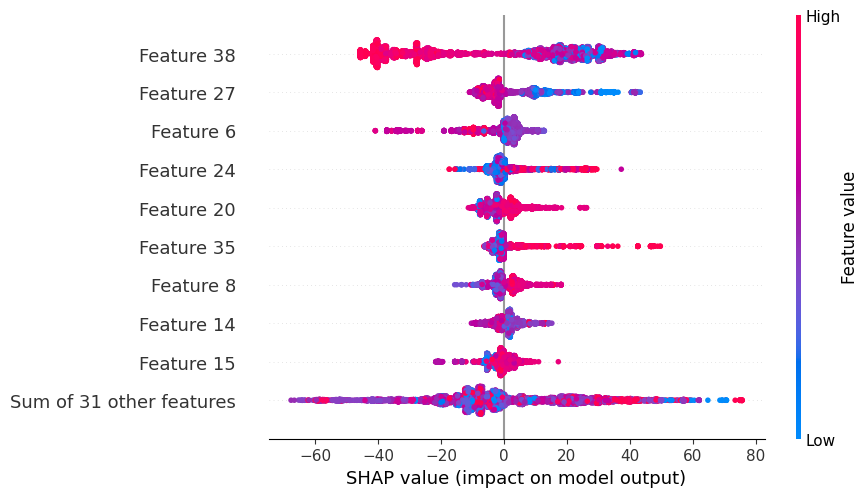

In [16]:
import xgboost
import shap

XG_train = X_train_transformed
yG_train = cluster_labels
XG_test = X_test_transformed
yG_test = test_clusters

model1 = xgboost.XGBRegressor().fit(XG_train, yG_train)
model2 = xgboost.XGBRegressor().fit(XG_test, yG_test)

explainer = shap.Explainer(model1) #model2
shap_values = explainer(XG_train) #XG_test

shap.plots.initjs()
shap.plots.beeswarm(shap_values) #, max_display=40
#shap.plots.waterfall(shap_values[0])
#shap.plots.force(shap_values[:500])

### n dimensions

In [17]:
# Highest-importance features (set var to easily change vis)
dim1 = "Component 38" 
dim2 = "Component 33"

fig = px.scatter(
    data_frame = train_df,
    x = dim1,
    y = dim2, # Change components to visualize each of the 30 dimensions
    color = "KMeans Cluster",
    hover_data = ["taxon_id", "Target", "Media Cluster"],
    opacity = 0.3
) 

# Add the test points as a scatter trace
fig.add_trace(
    go.Scatter(
        x=test_df[dim1],  # x coordinates
        y=test_df[dim2],  # y coordinates
        mode='markers',
        marker=dict(
            color='black',  
            size=5,  
            opacity=1.0 
        ),
        text=test_df["taxon_id"]  # marker hover text
    )
)

# Opacity slider
steps = []
for i in range(11):  # 0 to 1 in steps of 0.1
    step = dict(
        method="restyle",
        args=[{"marker.opacity": [i/20]}, [0]],  # Adjust opacity of the first trace only
        label=str(i/20)
    )
    steps.append(step)
sliders = [dict(
    active=3,  # initial value corresponding to opacity=0.3
    currentvalue={"prefix": "Opacity: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_coloraxes(showscale=False)
fig.update_layout(
    sliders=sliders,
    title="Fenix21 (Global Structure)",
    template="plotly_white",
    showlegend=False,
    #autosize=True,
    width=500, 
    height=500
)

#fig.update_yaxes(range=[2.25, 4.25])
#fig.update_xaxes(range=[2, 8])

fig.show()

### 2 dimensions

#### 2D Pipeline

In [18]:
# copy of model pipeline reduced to two dimensions, ***LEADS TO DISCONNECT IN DIMENSIONALITY REDUCTION STEPS***
visualization = Pipeline([
    ('scaler', StandardScaler()),   
    ('pca', PCA(n_components=150)),   
    ('umap', umap.UMAP(              
        metric="euclidean",
        n_epochs=500, 
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=2, # reduced for visualization
        n_neighbors=62, 
        min_dist=0 
        )) 
]) 

# Fit and transform the pipeline on the training and test data
#X_train_embedding = visualization.fit_transform(X_train) # fit pipeline and transform training data
#X_test_embedding = visualization.transform(X_test) # transform test data

# Cluster
#vclusterer = KMeans(n_clusters=182, random_state=RANDOM_SEED)
#vcluster_labels = vclusterer.fit_predict(X_train_embedding)
#vtest_clusters = vclusterer.predict(X_test_embedding)

# Metrics to compare to 40 dimensions
#vpca = visualization.named_steps['pca']
#vexplained_variance = vpca.explained_variance_ratio_
#vsilhouette_avg = silhouette_score(X_train_embedding, vcluster_labels)
#print(f"Total PCA explained variance: {vexplained_variance.sum()}")
#print(vclusterer.labels_.max()+1, "KMeans training clusters")
#print(f"Average Silhouette Score on KMeans clusters: {vsilhouette_avg}") # <0.25 implies poor clustering, 0.25<x<0.50 is fair, >50 is good

#### Visualization

In [19]:
# Training data
#train_2d = pd.DataFrame(X_train_embedding, columns=[f"Component {i+1}" for i in range(X_train_embedding.shape[1])])
#train_2d['Set'] = 'Training'
#train_2d['Target'] = y_train
#train_2d['KMeans Cluster'] = cluster_labels
#train_2d['taxon_id'] = df_train["taxon_id"]

# Media cluster labels
#media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
#media_clusters = media_clusters[["media_id", "Cluster"]]
#media_clusters = media_clusters.rename(columns={"media_id": "Target", "Cluster": "Media Cluster"})
#target_label_mapping = dict(zip(media_clusters['Target'], media_clusters['Media Cluster']))
#train_2d['Media Cluster'] = train_2d['Target'].map(target_label_mapping)

# Test data
#test_2d = pd.DataFrame(X_test_embedding, columns=[f"Component {i+1}" for i in range(X_test_embedding.shape[1])])
#test_2d['Set'] = 'Test'
#test_2d['Target'] = list(df_test['media_id'])
#test_2d['KMeans Cluster'] = test_clusters
#test_2d['taxon_id'] = list(df_test['taxon_id'])

# [Re-add 2d vis here (copy and paste from n-dimensions)]

# Prediction

In [20]:
predictor = merged.copy()
predictor = predictor.drop(predictor.iloc[:,0:42], axis=1)
predictor = predictor.drop('indices', axis=1)

#predictor.to_csv(os.path.join(DATA_DIR, "model", "TEST10.csv"), index=False) # save under different names for further analysis with each seed
predictor.head()

,Test Cluster,taxon_id,KNN Classify,RF Classify,neighbor_media_id,neighbor_taxon_id,Media Cluster
0,91,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,91,91,J262,45495.0,NaN
1,152,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,152,152,J84,38402.0,NaN
2,91,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,91,91,J237,75385.0,17.0
3,11,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,11,11,J256,375.0,NaN
4,152,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,91,152,J237,75385.0,17.0
